In [1]:
push!(LOAD_PATH, "/Users/jayyao/Documents/Research/TraceFormula/Module")
using GridapEM
using Gridap
using DelimitedFiles
using KrylovKit
using LinearAlgebra
using GridapMakie
using GLMakie

In [2]:
include("/Users/jayyao/Documents/Research/TraceFormula/Module/DefaultParameters.jl")

# Change default geometry parameters
rd = 0.7 #/ sqrt(2)
rt = rd + 0.2
resol = 40.0      # Number of points per wavelength
l1 = λ/resol      # Normal region
l2 = l1/2.0       # Design region
l3 = 2*l1         # PML

# Create mesh file
geo_param = CirRecGeometry(L, H, rd, rt, dpml, l1, l2, l3)
#geo_param = PeriodicGeometry(L, h1, h2, h3, ht, hs, dpml, l1, l2, l3)
meshfile_name = "geometry.msh"
#MeshGenerator(geo_param, meshfile_name)

# Apply gridap finite element analysis to mesh file
gridap = GridapFE(meshfile_name, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], [], flag_f)
#run(`gmsh geometry.msh`)

# Change default physics parameters
kb = VectorValue(2*π*0.,0)
LHp=[L / 2, H / 2]  # Start of PML for x,y > 0
LHn=[L / 2, H / 2]  # Start of PML for x,y < 0

phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)

# Change default control parameters
Bρ = true
ρv = 0.5
β = 80.0
α = 1.0 / (2 * 100)
K = 5
control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)


Info    : Reading 'geometry.msh'...
Info    : 60 entities
Info    : 28001 nodes
Info    : 56594 elements
Info    : Done reading 'geometry.msh'


ControllingParameters(true, true, [0.02, 0.02], 80.0, 0.5, 0.005, 15, 30, 5, 1.0, true, 0.5, 0.0, 0.75, 0.25)

In [ ]:
Nri = 101
α = 1.0 / (2 * 100)
control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)
Powers = zeros(Nri)
Rs = zeros(Nri)
Ncv = zeros(Nri)
Ncv2 = zeros(Nri)
for ri = 1 : Nri
    rd = (ri - 1) * 0.9 / (Nri - 1) + 0.1
    Rs[ri] = rd
    rt = rd + 0.2
    geo_param = CirRecGeometry(L, H, rd, rt, dpml, l1, l2, l3)
    meshfile_name = "geometry.msh"
    MeshGenerator(geo_param, meshfile_name)
    gridap = GridapFE(meshfile_name, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], [], flag_f)
    
    N = num_free_dofs(gridap.FE_U)
    ρ0 = ones(gridap.np)
    ρf_vec = ρf_ρ0(ρ0; control, gridap)
    ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
    ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
        
    A_mat = MatrixA(ρth; phys, control, gridap)
    B_mat = MatrixB(ρth; control, gridap)
    #@show sum(∫(ρth)gridap.dΩ_d) / sum(∫(1)gridap.dΩ_d)

    O_mat = MatrixOc(phys.k, phys.ϵ1; gridap)
    
    Neig = Int(ceil(ri / Nri * 30))
    G_ii, W_raw, info = eigsolve(x -> MatrixG(x; A_mat, B_mat, O_mat), rand(ComplexF64, N), Neig, :LM; krylovdim = 50)
    Ncv[ri] = num_contributing_values(G_ii, 0.99)
    Ncv2[ri] = num_contributing_values(G_ii, 0.9)
    @show Powers[ri] = sum(abs.(G_ii))
end

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve 22 (Line)
Info    : Meshing curve 23 (Line)
Info    : Meshing curve 24 (Line)
Info    : Meshing curve 25 (Circle)
Info    : Meshing curve 26 (Circle)
Info    :

In [ ]:
scene, layout = layoutscene(resolution=(1200/2, 1000/2))
ax = layout[1,1]=Axis(scene)
ms = 10
lin1 = lines!(ax, Rs, Powers)
# lin2 = lines!(ax,rs,FitPowers.(rs))
# lin3 = scatter!(ax,rs,power_rand,markersize=ms)
ax.xlabel="Design radius (λ)"
ax.ylabel="Power"
#ax.title="Optimized powers"
ax.xlabelsize=20
ax.ylabelsize=20

#Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
#axislegend(ax, [lin1,lin2,lin3],["Optimized","Quadratic Fitting","Uniform"], position = :lt,
#    orientation = :vertical)
scene

In [ ]:
ρ_circ(x, r) = (x[1]^2 + x[2]^2) < r^2 ? 1 : 0
r_init = (0.5 - 0.5 / sqrt(2)) * 0.0 + 0.5 / sqrt(2) - 0.015
lc_temp(v) = ∫(v * x->ρ_circ(x, r_init))gridap.dΩ
ρc_vec = assemble_vector(lc_temp, gridap.FE_P)
ρ_init = ρ_extract(ρc_vec; gridap)
#ρ_init[ρ_init .< 0.5] .= 0
ρ_init[ρ_init .> 0] .= 1#(0.5 / r_init)^2 /2
sum(ρ_init) / gridap.np, maximum(ρ_init)

In [ ]:
ρ_init = Interpolated_Initial_Guess(gridap)
ρf_vec = ρf_ρ0(ρ_init; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
fig, ax, plt = plot(gridap.Ω, ρth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(H))
ax.title = "ε"
limits!(ax, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
fig

In [3]:
ρ_init = ones(gridap.np) * 0.5 
#ρW_temp = readdlm("ρW_opt_value.txt", Float64)
#ρW_temp = ρW_temp[:]
#ρ_init = ρW_temp[1 : gridap.np]
#ρ_init[ρ_init .< 0.5] .= 0
#ρ_init[ρ_init .>= 0.5] .= 1.0
#r = [0.02 * λ, 0.02 * λ]  # Filter radius
#Q_list = [20, 50, 100, 500, 1000, 1000, 1000]
Q_list = [1000, 1000, 1000, 1000, 1000]
β_list = [80.0, 80.0, 80.0, 80.0, 80.0]
#β_list = [5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]

g_opt = 0
for bi = 2 : 5
    β = β_list[bi]
    α = 1.0 / (2 * Q_list[bi])
    K = 20
    phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)

    if bi == 1
        g_opt, ρW_opt = gρW_optimize(ρ_init, 1e-6, 200, :LD_MMA; phys,control, gridap)
    else
        g_opt, ρW_opt = gρW_optimize([], 1e-6, 200, :LD_MMA; phys, control, gridap)
    end
    if isfile("ρW_opt.value.txt")
        run(`rm ρW_opt_value.txt`)
    end
    open("ρW_opt_value.txt", "w") do iop
        for i = 1 : length(ρW_opt)
            ρW_temp = ρW_opt[i]
            write(iop, "$ρW_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end

g_value = 175.85028946262534
g_value = 100.64393539899547
g_value = 102.95098629461569
g_value = 126.73716512303953
g_value = 176.9854786775147
g_value = 29.76523680234573
g_value = 103.96956332627211
g_value = 175.42221480159185
g_value = 177.24542236767275
g_value = 177.057792351181
g_value = 177.40937719394992
g_value = 147.4689047609015
g_value = 177.31855116687603
g_value = 177.51677326206297
g_value = 176.86954060056624
g_value = 177.65539244319586
g_value = 152.17251301126504
g_value = 177.69849963603085
g_value = 177.98191755670922
g_value = 178.08639149549617
g_value = 178.1819344254822
g_value = 178.23791655989376
g_value = 178.64706769253644
g_value = 111.64137720952274
g_value = 176.61304954107504
g_value = 178.8367052299655
g_value = 171.90872974256973
g_value = 179.04207762303292
g_value = 144.41028865410945
g_value = 179.1647844381466
g_value = 179.3248704720677
g_value = 179.69321567708505
g_value = 179.84907908959474
g_value = 179.94002220911332
g_value = 180.531175377

g_value = 201.29626615093937
g_value = 182.98612921126343
g_value = 201.25819016735252
g_value = 201.3496192558966
g_value = 200.71570201729645
g_value = 201.4119288368401
g_value = 193.60383276193798
g_value = 201.48612764801453
g_value = 201.27909449704808
g_value = 201.52288722578183
g_value = 194.31355026647668
g_value = 201.49894188734336
g_value = 201.53472983689466
g_value = 201.5693444131972
g_value = 200.9442762561141
g_value = 201.61020392428202
g_value = 201.6516158902392
g_value = 198.03548526857242
g_value = 201.62850000926193
g_value = 201.7099206660171
g_value = 201.5465875914717
g_value = 201.71804738455364
g_value = 201.13986844822355
g_value = 201.72719004226354
g_value = 201.54330607340924
g_value = 201.7416987391843
g_value = 200.17641493497558
g_value = 201.7464291917831
g_value = 201.6827392390056
g_value = 201.76381844822868
g_value = 201.37861490891504
g_value = 201.7674166151672
g_value = 201.77090679776506
g_value = 201.77353185862816
g_value = 201.78836129148

g_value = 213.51901401010207
g_value = 213.52576322909377
g_value = 213.525799872745
g_value = 213.5262533637969
g_value = 213.52648170407656
g_value = 213.5279410772608
g_value = 213.427000829274
g_value = 213.52893492339766
g_value = 213.4739683229271
g_value = 213.52988065007386
g_value = 213.5038041736792
g_value = 213.53009243979295
g_value = 213.53025760955205
g_value = 213.53046991339613
g_value = 213.53058439629837
g_value = 213.53190967205506
g_value = 213.010762560692
g_value = 213.52932155769474
g_value = 213.53229994942518
g_value = 213.52182777020505
g_value = 213.53333163248845
g_value = 213.522734957416
g_value = 213.5337357987053
g_value = 213.53397791192796
g_value = 213.52690589108096
g_value = 213.5343347992813
g_value = 213.46472646273028
g_value = 213.53466292794755
g_value = 213.53343185944797
numevals = opt.numevals = 200
g_value = 213.53466292794755
g_value = 168.85931840861733
g_value = 170.72255077940451
g_value = 186.6837245742352
g_value = 213.87022758041203

sum(∫(ρth) * gridap.dΩ_d) / sum(∫(1) * gridap.dΩ_d) = 0.4999999078276505


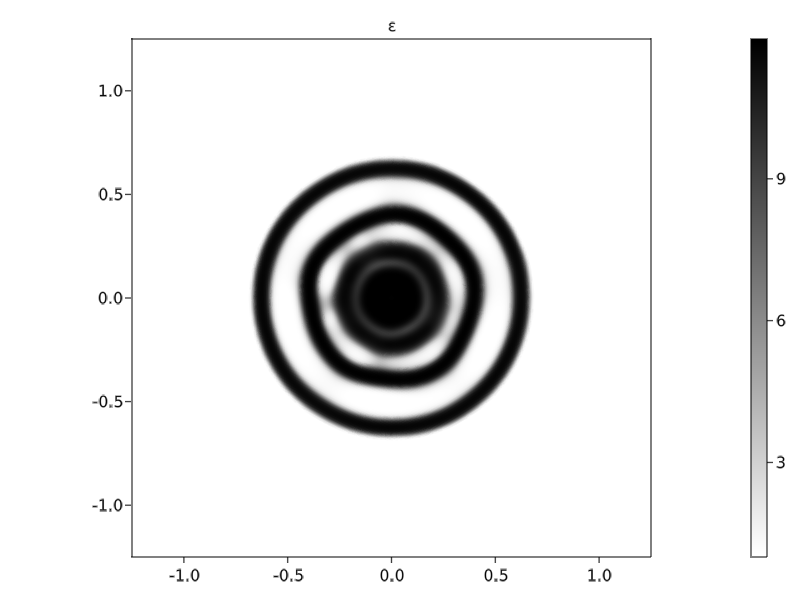

In [4]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    ρW_max = readdlm("ρW_opt_value.txt", Float64)
    ρW_max = ρW_max[:]
    ρ0 = ρW_max[1 : gridap.np]
    W_mat = reinterpret(ComplexF64, reshape(ρW_max[gridap.np + 1 : end], (2 * N, control.K)))
else
    ρ0 = ones(gridap.np)
end
 
ρf_vec = ρf_ρ0(ρ0; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
        
A_mat = MatrixA(ρth; phys, control, gridap)
B_mat = MatrixB(ρth; control, gridap)
@show sum(∫(ρth)gridap.dΩ_d) / sum(∫(1)gridap.dΩ_d)

A0_mat = MatrixA0(phys, control, gridap)
O_mat = MatrixOc(phys.k, phys.ϵ1; gridap)

G_ii, V_raw, info = eigsolve(x -> A_mat \ (A0_mat * x), rand(ComplexF64, N), 10, :LM)
G_trace, W_raw, info = eigsolve(x -> MatrixG(x; A_mat, B_mat, O_mat), rand(ComplexF64, N), min(control.K, 10), :LM; krylovdim = 30)
if !ImportFromFile
    W_mat = rand(ComplexF64, N, control.K)
    for ib = 1 : control.K
        W_mat[:, ib] = W_raw[ib]
    end
end


V_mat = rand(ComplexF64, N, control.K)
for ib = 1 : min(control.K, 10)
    V_mat[:, ib] = V_raw[ib]
end
U_mat = A_mat \ (B_mat * W_mat)
uh_eig = FEFunction(gridap.FE_U, V_mat[:, 1])
uh = FEFunction(gridap.FE_U, U_mat[:, 1])

fig, ax, plt = plot(gridap.Ω, real(1 + 11 * ρth), colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(H))
ax.title = "ε"
limits!(ax, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/shape.png", fig)
fig

In [ ]:
x_eig = W_mat[:, 3]
g_trace = x_eig' * MatrixG(x_eig; A_mat, B_mat, O_mat) / (x_eig' * x_eig)
abs(g_trace)

In [ ]:
(abs.(G_trace))

In [ ]:
# r = 0.5 uniform g = 13.301107377129648
# 167.30018269788212 12.577913849905718
sum(abs.(G_trace)), g_ρ(ρ0; O_mat, W_mat, phys, control, gridap)

In [ ]:
uh = FEFunction(gridap.FE_U, B_mat * U_mat[:, 1])
fig1, ax1, plt1 = plot(gridap.Ω, imag(uh), colormap = :bwr)
Colorbar(fig1[1,2], plt1)
ax1.aspect = AxisAspect(L/(H))
ax1.title = "real(Hz)"
limits!(ax1, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
fig1

In [ ]:
uh_eig = FEFunction(gridap.FE_U, V_mat[:, 2])
uh = FEFunction(gridap.FE_U, U_mat[:, 2])
fig1, ax1, plt1 = plot(gridap.Ω, -real(uh), colormap = :bwr)
Colorbar(fig1[1,2], plt1)
ax1.aspect = AxisAspect(L/(H))
ax1.title = "real(Hz)"
limits!(ax1, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/s_mode_2.png", fig1)
fig2, ax2, plt2 = plot(gridap.Ω, real(uh_eig), colormap = :bwr)
Colorbar(fig2[1,2], plt2)
ax2.aspect = AxisAspect(L/(H))
ax2.title = "real(Hz)"
limits!(ax2, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/t_mode_2.png", fig2)
fig1


In [ ]:
fig2

In [ ]:

g_values = open(readdlm,"gvalue.txt")
#g_values = open(readdlm,"Results/L0.6_0.05_1.2.txt")
GLMakie.scatter(range(1, length(g_values[:]), step=1), g_values[:], markersize = 2)


In [ ]:
N = num_free_dofs(gridap.FE_U)
ρW0 = rand(gridap.np + 2 * N * control.K) * 1
δρW = rand(gridap.np + 2 * N * control.K) * 1e-6

O_mat = MatrixOc(phys.ω, phys.ϵ1; gridap)

grad = zeros(gridap.np + 2 * N * control.K)
g1 = g_ρW(ρW0 + δρW, []; O_mat, phys, control, gridap)
g0 = g_ρW(ρW0, grad; O_mat, phys, control, gridap)
g1 - g0, grad' * δρW

In [ ]:
grad_max = zeros(gridap.np + 2 * N * control.K)
g0 = g_ρW(ρW_max, grad_max; O_mat, phys, control, gridap)
norm(grad_max), g0

In [ ]:
α_step = 0.01
g_ρW(ρW_max+grad_max*α_step, []; O_mat, phys, control, gridap)-g0

In [ ]:
grad = zeros(gridap.np + 2 * N * control.K)
δρW = rand(gridap.np + 2 * N * control.K) * 1e-6
g1 = g_ρW(ρW_max+ δρW, []; O_mat, phys, control, gridap)
g0 = g_ρW(ρW_max, grad; O_mat, phys, control, gridap)
g1 - g0, grad' * δρW

In [ ]:
g0